In [1]:
import statsmodels.discrete.count_model as smdc

import numpy as np
import pandas as pd
import pymc
import matplotlib.pyplot as plt
import bambi as bmb
import arviz as az

In [ ]:
class DataSet(dict):
    def __init__(self, path):
        print('initializing dataset')
        self.filepath = path
        self.parquet = pq.ParquetFile(self.filepath)
    
    def __getitem__(self, key):
        try:
            return self.parquet.read([key]).to_pandas()[key]
        except:
            raise KeyError

    def __reduce__(self):
        #return self.parquet.read().to_pandas().__reduce__()
        return (self.__class__, (self.filepath, ))


def poisson_model(counts_parq, patsy_formula):
    counts_model_poisson = smdc.GeneralizedPoisson.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_poisson

def zi_poisson_model(counts_parq, patsy_formula):
    counts_model_zi_poisson = smdc.ZeroInflatedPoisson.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_zi_poisson

def negative_binomial_model(counts_parq, patsy_formula):
    counts_model_negative_binomial = smdc.NegativeBinomialP.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_negative_binomial

def zi_negative_binomial_model(counts_parq, patsy_formula):
    counts_model_zi_negative_binomial = smdc.ZeroInflatedNegativeBinomialP.from_formula(formula = patsy_formula, data = counts_parq)

    return counts_model_zi_negative_binomial

def get_stats(fit_model):
    print('getting stats')
    # available stats come from here https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.CountResults.html

    aic = fit_model.aic
    bic = fit_model.bic
    loglike = fit_model.llf
    llr_chi2 = fit_model.llr
    llr_chip = fit_model.llr_pvalue
    pseudr = fit_model.prsquared
    resid = fit_model.resid
    converged = fit_model.converged

    return [converged, aic, bic, loglike, llr_chi2, llr_chip, pseudr] # list(resid)

# ZINB

In [3]:
name = 'ZINB'
ndraws = 500000
psi = 0.5
mu = 1
alpha = 1
random_seed = 18
name='ZINB'

In [4]:
zinb = pymc.ZeroInflatedNegativeBinomial.dist(psi=psi, mu = mu, alpha = alpha)
zinb_draws = pymc.draw(zinb, draws=ndraws, random_seed=random_seed)

df = pd.DataFrame({'y': zinb_draws})

## trying out Bambi

In [5]:
model = bmb.Model("y~1", df, family="zero_inflated_negativebinomial")
model_fit = model.fit(draws = 10000, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, psi, Intercept]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1067 seconds.


In [ ]:
az.summary(model_fit)

In [ ]:
az.plot_trace(model_fit, compact=False)

## statsmodels, old not working great

In [6]:
model = smdc.ZeroInflatedNegativeBinomialP(endog = zinb_draws, exog = xvar)
model_fit = model.fit(maxiter=500)
model_fit.summary2()

NameError: name 'xvar' is not defined

In [7]:
diag = model_fit.get_diagnostic()
diag.plot_probs()

NameError: name 'model_fit' is not defined

In [137]:
model

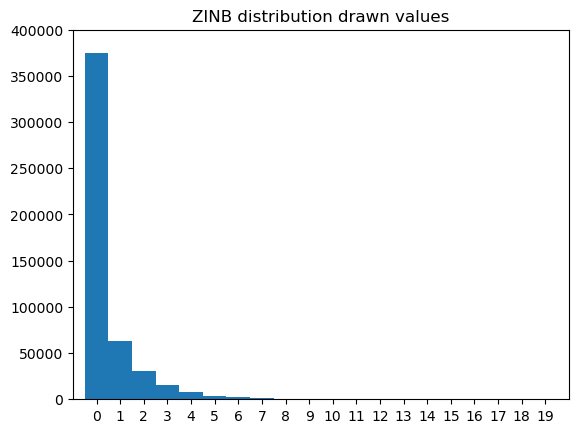

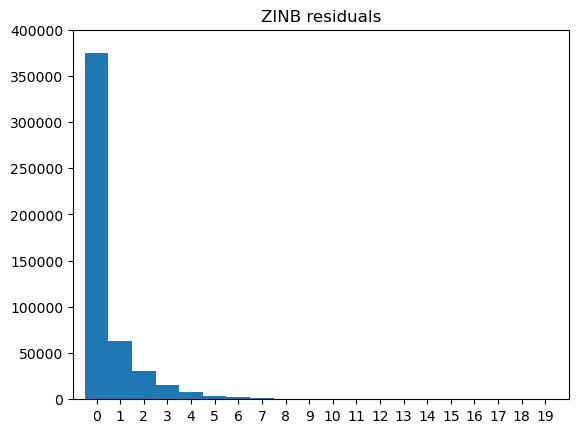

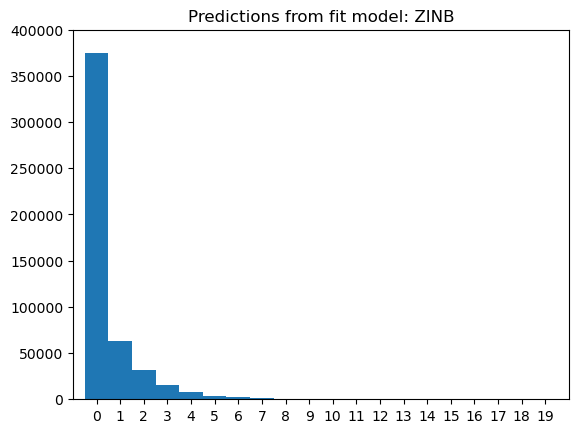

In [135]:
bins = np.arange(21) - 0.5



plt.hist(zinb_draws, bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,400000])
plt.title('%s distribution drawn values' % name)
plt.show()

plt.hist(model_fit.resid, bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,400000])
plt.title('%s residuals' % name)
plt.show()

plt.hist(model_fit.get_distribution().rvs(), bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,400000])
plt.title('Predictions from fit model: %s' % name)
plt.show()

In [136]:
np.unique(model_fit.resid, return_counts=True)

(array([-0.49885135,  0.50114865,  1.50114865,  2.50114865,  3.50114865,
         4.50114865,  5.50114865,  6.50114865,  7.50114865,  8.50114865,
         9.50114865, 10.50114865, 11.50114865, 12.50114865, 13.50114865,
        14.50114865, 15.50114865, 16.50114865]),
 array([374949,  62964,  31034,  15444,   7861,   3800,   1977,    992,
           484,    244,    121,     69,     38,     13,      3,      4,
             1,      2]))

# NB

In [5]:
ndraws = 500000
mu = 1
alpha = 1
random_seed = 18
name='NB'

In [6]:
nb = pymc.NegativeBinomial.dist(mu = mu, alpha = alpha)
nb_draws = pymc.draw(nb, draws=ndraws, random_seed=random_seed)


df = pd.DataFrame({'y': nb_draws})

## trying out Bambi

In [7]:
model = bmb.Model("y~1", df, family="negativebinomial")
model_fit = model.fit(draws = 100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept]


Output()

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 979 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [8]:
model_fit

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
model_sum = az.summary(model_fit)

In [10]:
model_sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.988,0.005,0.980,0.996,0.0,0.0,525.0,365.0,1.02
Intercept,0.001,0.002,-0.003,0.005,0.0,0.0,432.0,224.0,1.01


In [11]:
model_sum.to_csv('test.csv')

In [12]:
model_fit.to_dataframe()

,chain,draw,"(posterior, alpha)","(posterior, Intercept)","(sample_stats, perf_counter_diff)","(sample_stats, largest_eigval)","(sample_stats, index_in_trajectory)","(sample_stats, diverging)","(sample_stats, smallest_eigval)","(sample_stats, tree_depth)",...,"(sample_stats, perf_counter_start)","(sample_stats, reached_max_treedepth)","(sample_stats, energy_error)","(sample_stats, energy)","(sample_stats, n_steps)","(sample_stats, max_energy_error)","(sample_stats, step_size)","(sample_stats, step_size_bar)","(sample_stats, lp)","(sample_stats, acceptance_rate)"
0,0,0,0.984837,0.001987,0.608341,NaN,3,False,NaN,2,...,1.210869e+06,False,-0.422158,693433.658439,3.0,1.177518,1.296608,1.231476,-693429.479706,0.631969
1,0,1,0.984837,0.001987,0.324045,NaN,0,False,NaN,1,...,1.210870e+06,False,0.000000,693430.107817,1.0,0.304062,1.296608,1.231476,-693429.479706,0.737815
2,0,2,0.988169,0.000405,0.611160,NaN,-1,False,NaN,2,...,1.210870e+06,False,-0.116977,693429.441701,3.0,-0.116977,1.296608,1.231476,-693429.133244,0.988382
3,0,3,0.987997,0.001779,0.551565,NaN,2,False,NaN,2,...,1.210871e+06,False,0.033675,693429.275862,3.0,0.037756,1.296608,1.231476,-693429.226957,0.975820
4,0,4,0.983638,0.003101,0.642263,NaN,1,False,NaN,2,...,1.210872e+06,False,0.314379,693430.198706,3.0,0.314379,1.296608,1.231476,-693430.145547,0.833433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,3,95,0.983302,-0.000508,0.154868,NaN,-1,False,NaN,2,...,1.210998e+06,False,0.196339,693429.853526,3.0,0.196339,1.386911,1.301251,-693429.776570,0.891056
396,3,96,0.995951,0.001167,0.149969,NaN,2,False,NaN,2,...,1.210998e+06,False,0.282171,693431.242720,3.0,0.554031,1.386911,1.301251,-693430.498539,0.675688
397,3,97,0.979590,0.001539,0.152465,NaN,2,False,NaN,2,...,1.210999e+06,False,0.062775,693430.984085,3.0,-0.325477,1.386911,1.301251,-693430.655999,0.979718
398,3,98,0.978197,0.002249,0.075220,NaN,-1,False,NaN,1,...,1.210999e+06,False,0.279906,693431.914423,1.0,0.279906,1.386911,1.301251,-693431.388886,0.755855


: 

In [13]:
model.predict(model_fit, kind="response")


In [ ]:

az.plot_ppc(model_fit)


NameError: name 'model_fit' is not defined

AttributeError: module 'bambi' has no attribute 'sample_posterior_predictive'

## statsmodels old stuff

In [38]:
model = smdc.NegativeBinomialP(endog = nb_draws, exog = xvar)
model_fit = model.fit(maxiter=500)
model_fit.summary()

Optimization terminated successfully.
         Current function value: 1.386852
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomialP Regression Results                     
==============================================================================
Dep. Variable:                      y   No. Observations:               500000
Model:              NegativeBinomialP   Df Residuals:                   499999
Method:                           MLE   Df Model:                            0
Date:                Wed, 16 Oct 2024   Pseudo R-squ.:               9.589e-11
Time:                        13:50:21   Log-Likelihood:            -6.9343e+05
converged:                       True   LL-Null:                   -6.9343e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.406      0.685      -0.003       0.005
alpha          1.0123      0.005    203.874      0.000       1.003       1.022
==============================================================================
"""

In [39]:
model_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: NegativeBinomialP
====================================================================
Model:              NegativeBinomialP Pseudo R-squared: 0.000       
Dependent Variable: y                 AIC:              1386856.2615
Date:               2024-10-16 13:50  BIC:              1386878.5062
No. Observations:   500000            Log-Likelihood:   -6.9343e+05 
Df Model:           0                 LL-Null:          -6.9343e+05 
Df Residuals:       499999            LLR p-value:      nan         
Converged:          1.0000            Scale:            1.0000      
Method:             MLE                                             
-----------------------------------------------------------------------
          Coef.     Std.Err.       z        P>|z|      [0.025    0.975]
-----------------------------------------------------------------------
const     0.0008      0.0020      0.4057    0.6850    -0.0031    0.0047
alpha     1.0123      0.0050    203.8736    0.0000     1.0025    1.0220
====================================================================

"""

In [130]:
model_fit.resid

array([-1.000814e+00, -1.000814e+00,  9.991860e-01, ...,  6.999186e+00,
       -1.000814e+00, -8.140000e-04])

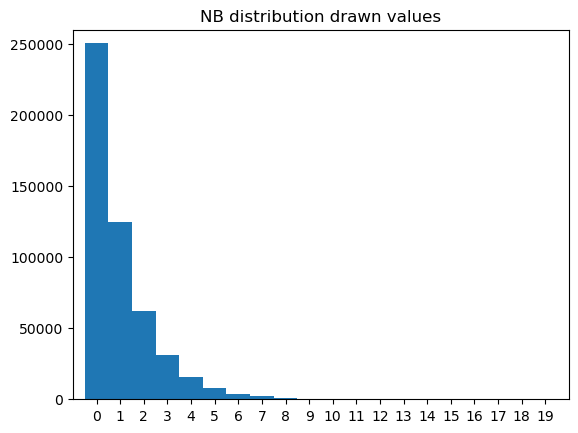

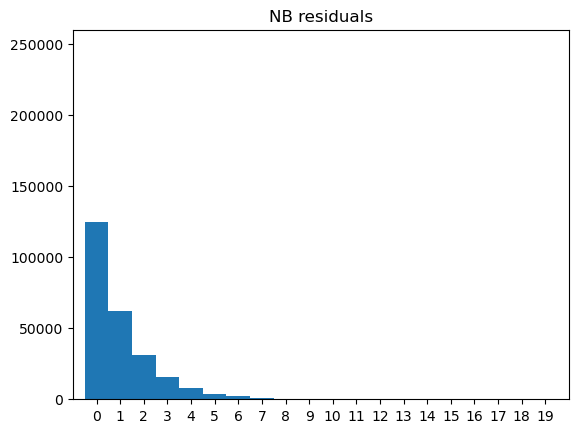

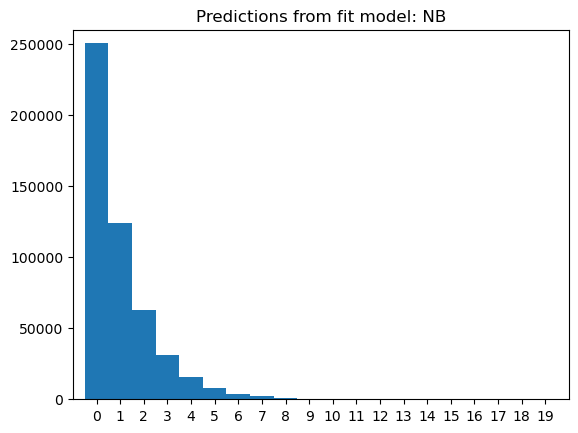

In [270]:
bins = np.arange(21) - 0.5

plt.hist(nb_draws, bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,260000])
plt.title('%s distribution drawn values' % name)
plt.show()

plt.hist(model_fit.resid, bins=bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,260000])
plt.title('%s residuals' % name)
plt.show()

plt.hist(model_fit.get_distribution().rvs(), bins = bins)
plt.xticks(range(20))
plt.xlim([-1, 20])
plt.ylim([0,260000])
plt.title('Predictions from fit model: %s' % name)
plt.show()

In [269]:
model_fit.prsquared

9.58884083246403e-11

In [23]:
model.loglike(model_fit.params)

-693426.1307369282